In [20]:
# ==========================================
# MASTER CLEANING + FULL NORMALIZATION
# ==========================================

import pandas as pd
import numpy as np
import unicodedata

# -------------------------
# Load cleaned dataset
# -------------------------
df = pd.read_csv("/kaggle/input/fantasy-football/cleaned_merged_seasons.csv")
print("Initial shape:", df.shape)

# 🧹 Normalize column names: lowercase, remove spaces, underscores, etc.
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)
print("\nNormalized column names:\n", df.columns.tolist())

# -------------------------
# Standardize key column names if variants exist
# -------------------------
rename_map = {}
if "gw" not in df.columns:
    for alt in ["gameweek", "round", "gw_x", "gw_y"]:
        if alt in df.columns:
            rename_map[alt] = "gw"
            break

if "season_x" not in df.columns and "season" in df.columns:
    rename_map["season"] = "season_x"

df = df.rename(columns=rename_map)
print("\nRenamed columns (if needed):", rename_map)

# Define main columns
name_col = "name"
season_col = "season_x"
gw_col = "gw"
tp_col = "total_points"
position_col = "position"

# -------------------------
# Drop unwanted or irrelevant columns
# -------------------------
drop_exact = ["team_x", "kickoff_time",  "influence", "creativity",
              "threat", "round", "value", "opponent_team"]

drop_cols = [c for c in drop_exact if c in df.columns]
            

if drop_cols:
    print(f"\nDropping irrelevant columns: {drop_cols}")
    df = df.drop(columns=drop_cols)

# -------------------------
# Handle fake/null placeholders
# -------------------------
fake_nulls = ["", " ", "  ", "nan", "null", "none", "-", "--", "n/a", "na"]
df = df.replace(fake_nulls, np.nan)

# -------------------------
# Normalize all string columns (lowercase, remove accents/spaces)
# -------------------------
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = (
        df[col].astype(str)
        .map(lambda x: unicodedata.normalize("NFKC", x))
        .str.strip()
        .str.lower()
        .replace(r"\s+", " ", regex=True)
    )

# -------------------------
# Normalize positions (e.g., gk/gkp → goalkeeper)
# -------------------------
if "position" in df.columns:
    pos_map = {
        "gk": "goalkeeper", "gkp": "goalkeeper", "goalkeeper": "goalkeeper",
        "keeper": "goalkeeper", "goalie": "goalkeeper",
        "def": "defender", "defender": "defender", "df": "defender",
        "cb": "defender", "rb": "defender", "lb": "defender", "wingback": "defender",
        "mid": "midfielder", "midfielder": "midfielder", "mf": "midfielder",
        "cm": "midfielder", "am": "midfielder", "lm": "midfielder", "rm": "midfielder",
        "fwd": "forward", "forward": "forward", "fw": "forward",
        "striker": "forward", "attacker": "forward", "st": "forward", "cf": "forward"
    }
    df["position"] = df["position"].map(pos_map).fillna(df["position"])

# -------------------------
# Convert numeric-like columns
# -------------------------
numeric_like = [
    "total_points", "minutes", "goals_scored", "assists",
    "clean_sheets", "goals_conceded", "saves",
    "yellow_cards", "red_cards", "bonus", "ict_index", "gw" , "transfers_balance", "selected"  
]
for col in numeric_like:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Ensure season is a string and GW is integer
if "season_x" in df.columns:
    df["season_x"] = df["season_x"].astype(str)
if "gw" in df.columns:
    df["gw"] = pd.to_numeric(df["gw"], errors="coerce").astype("Int64")

# -------------------------
# ✅ Remove duplicates logically (keep highest total_points)
# -------------------------
subset = [c for c in ["name", "season_x", "gw", "opp_team_name" , "element"] if c in df.columns]
if subset:
    print(f"\nChecking duplicates by {subset} ...")
    before = len(df)
    
    # Sort by total_points (highest first), then drop duplicates keeping the first
    df = (
        df.sort_values(by=[tp_col] if tp_col in df.columns else subset, ascending=False)
          .drop_duplicates(subset=subset, keep="first")
          .reset_index(drop=True)
    )
    
    removed = before - len(df)
    print(f"Removed {removed} duplicate rows (kept highest total_points per player-season-GW).")

# -------------------------
# Safe sorting
# -------------------------
sort_cols = [c for c in ["name", "season_x", "gw"] if c in df.columns]
if sort_cols:
    df = df.sort_values(by=sort_cols).reset_index(drop=True)

# -------------------------
# Final summary
# -------------------------
print("\n✅ Final dataset shape:", df.shape)
print("Remaining duplicates:", df.duplicated(subset=subset).sum())
display(df.head())

# -------------------------
# Save final cleaned file
# -------------------------
df.to_csv("cleaned_fpl_dataset_normalized.csv", index=False)
print("\n💾 Saved normalized dataset as 'cleaned_fpl_dataset_normalized.csv'")


/tmp/ipykernel_37/3441417603.py:12: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/fantasy-football/cleaned_merged_seasons.csv")


Initial shape: (96169, 37)

Normalized column names:
 ['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards', 'gw']

Renamed columns (if needed): {}

Dropping irrelevant columns: ['team_x', 'kickoff_time', 'influence', 'creativity', 'threat', 'round', 'value', 'opponent_team']

Checking duplicates by ['name', 'season_x', 'gw', 'opp_team_name', 'element'] ...
Removed 0 duplicate rows (kept highest total_points per player-season-GW).

✅ Final dataset shape: (96169, 29)
Remaining duplicates: 0


,season_x,name,position,assists,bonus,bps,clean_sheets,element,fixture,goals_conceded,...,selected,team_a_score,team_h_score,total_points,transfers_balance,transfers_in,transfers_out,was_home,yellow_cards,gw
0,2020-21,aaron connolly,forward,0,0,-3,0,78,7,2,...,32205,3.0,1.0,1,0,0,0,True,0,1
1,2020-21,aaron connolly,forward,0,2,27,1,78,16,0,...,35030,3.0,0.0,8,-1161,5332,6493,False,0,2
2,2020-21,aaron connolly,forward,0,0,2,0,78,19,2,...,55356,3.0,2.0,2,13526,26823,13297,True,0,3
3,2020-21,aaron connolly,forward,0,0,7,0,78,32,3,...,55125,2.0,4.0,2,-1311,10399,11710,False,0,4
4,2020-21,aaron connolly,forward,1,0,13,0,78,40,0,...,46774,1.0,1.0,4,-8992,5860,14852,False,0,5



💾 Saved normalized dataset as 'cleaned_fpl_dataset_normalized.csv'


- Fully cleans and normalizes the Fantasy Football dataset  
- Standardizes column names and unifies naming conventions  
- Removes irrelevant columns and placeholder nulls  
- Normalizes text fields (lowercase, trimmed, accent-free)  
- Standardizes player positions (e.g., GK → goalkeeper)  
- Converts numeric-like columns to proper numeric types  
- Removes logical duplicates, keeping the highest total points  
- Safely sorts data by player, season, and gameweek  
- Saves the final, analysis-ready file as **cleaned_fpl_dataset_normalized.csv**


Dataset loaded successfully.


/tmp/ipykernel_37/3674579136.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['form'].fillna(0, inplace=True)



Analyzing Question A: Which player position scores the highest on average per season?
Saved visualization to 'position_performance_seasonal.png'


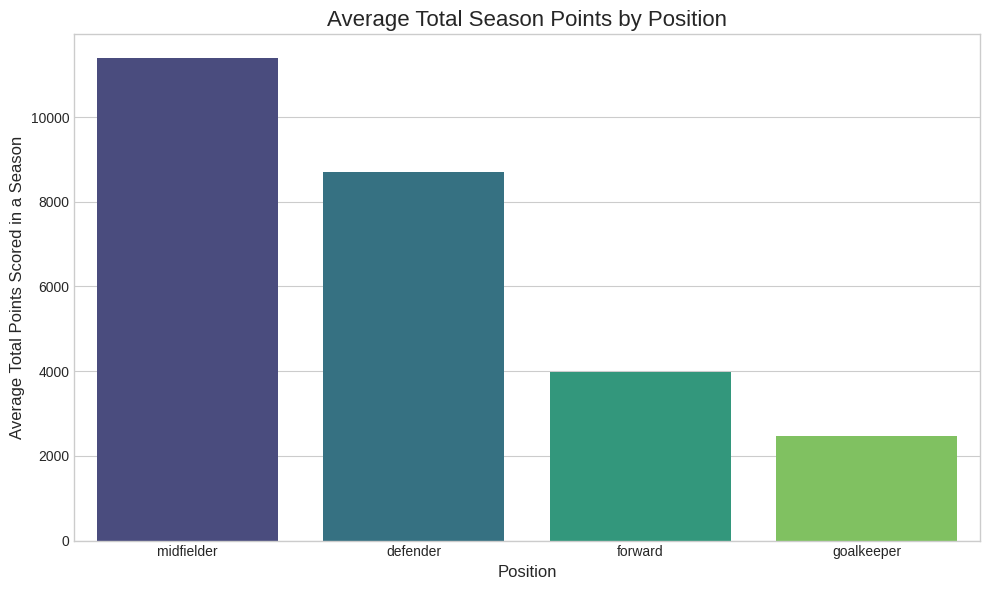


Analyzing Question B: How did the top players' form evolve in the 2022-23 season?

Top 5 players by average form: ['erling haaland', 'harry kane', 'mohamed salah', 'martin ødegaard', 'gabriel martinelli silva']
Top 5 players by total points: ['erling haaland', 'harry kane', 'mohamed salah', 'martin ødegaard', 'marcus rashford']

Are they the same?  No


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Saved visualization to 'top_players_form.png'


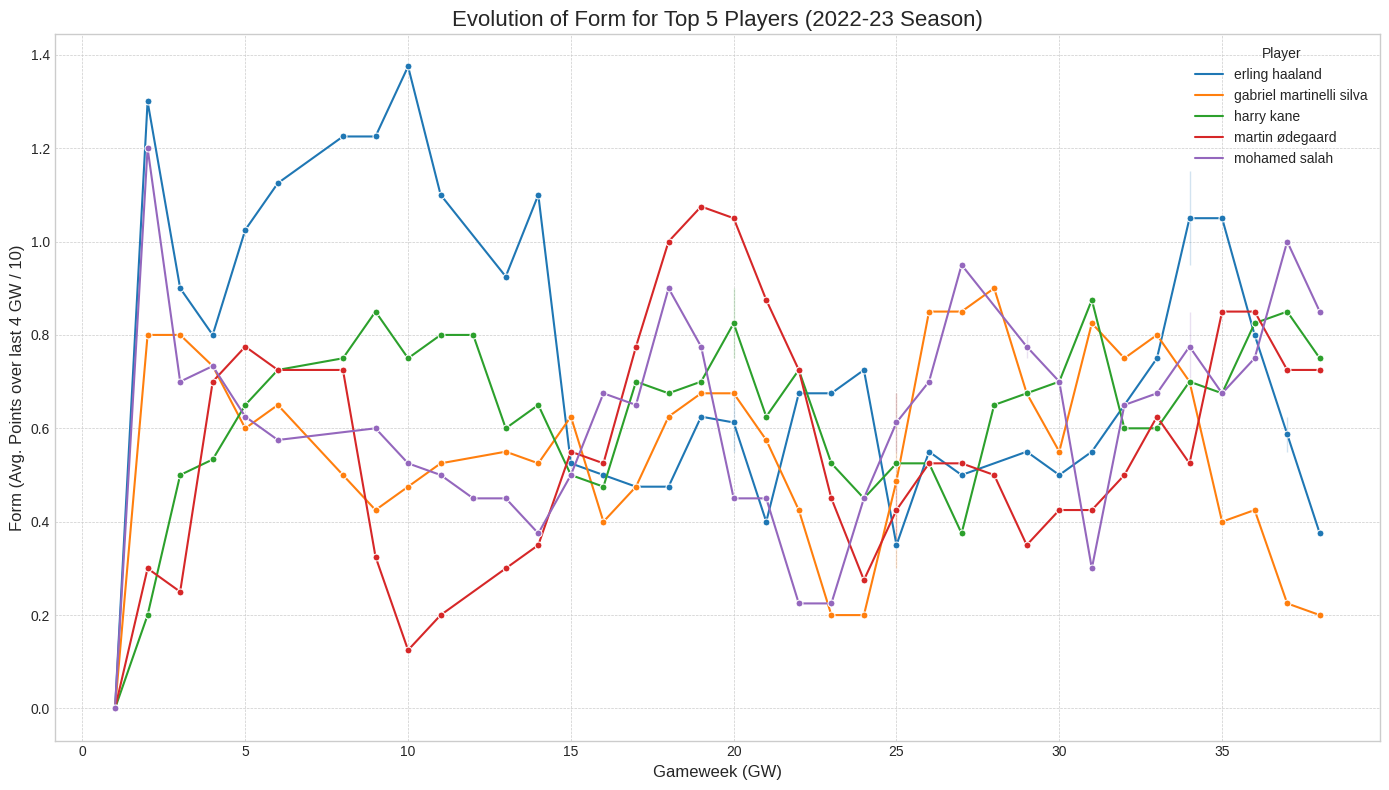


✅ Saved dataset with 'season_total_points' & 'form' → cleaned_fpl_dataset_with_form.csv


In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# -------------------------
# Load your cleaned dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the Dataset ---
# Updated file path
try:
    df = pd.read_csv('/kaggle/working/cleaned_fpl_dataset_normalized.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    # Corrected error message
    print("Error: '/kaggle/working/cleaned_fpl_dataset_normalized.csv' not found. Please check the file path.")
    exit()

# --- Data Preparation ---
# Standardize 'round' column to the new 'gw' (lowercase) if it exists
if 'round' in df.columns and 'gw' not in df.columns:
    df.rename(columns={'round': 'gw'}, inplace=True)

# Create the 'form' column using the new 'season_x' and 'gw' column names
df.sort_values(by=['name', 'season_x', 'gw'], inplace=True)
df['form'] = df.groupby(['name', 'season_x'])['total_points'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean().shift(1) / 10
)
df['form'].fillna(0, inplace=True)


# --- Data Engineering Question A: Position Performance (Per Season) ---
print("\nAnalyzing Question A: Which player position scores the highest on average per season?")

plt.style.use('seaborn-v0_8-whitegrid')
fig_pos, ax_pos = plt.subplots(figsize=(10, 6))

# *UPDATED LOGIC*: Group by season and position, sum points, then find the average of that sum per position.
# Uses the correct 'season_x' column name.
position_seasonal_points = df.groupby(['season_x', 'position'])['total_points'].sum().groupby('position').mean().sort_values(ascending=False)

# Create the bar plot
sns.barplot(x=position_seasonal_points.index, y=position_seasonal_points.values, ax=ax_pos, palette="viridis")

# Updated plot titles to reflect the "per season" calculation
ax_pos.set_title('Average Total Season Points by Position', fontsize=16)
ax_pos.set_xlabel('Position', fontsize=12)
ax_pos.set_ylabel('Average Total Points Scored in a Season', fontsize=12)
ax_pos.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('position_performance_seasonal.png')
print("Saved visualization to 'position_performance_seasonal.png'")
plt.show()


# --- Data Engineering Question B: Top Player Form Evolution (2022-23) ---
print("\nAnalyzing Question B: How did the top players' form evolve in the 2022-23 season?")

# Filter for the 2022-23 season using the 'season_x' column
df_22_23 = df[df['season_x'] == '2022-23'].copy()

if not df_22_23.empty:
    # Identify top 5 players by average form
    top_5_form_players = df_22_23.groupby('name')['form'].mean().nlargest(5).index.tolist()

    # Identify top 5 players by total points for comparison
    top_5_points_players = df_22_23.groupby('name')['total_points'].sum().nlargest(5).index.tolist()

    print(f"\nTop 5 players by average form: {top_5_form_players}")
    print(f"Top 5 players by total points: {top_5_points_players}")
    print("\nAre they the same? ", "Yes" if set(top_5_form_players) == set(top_5_points_players) else "No")

    # Filter for the top 5 players by form
    top_players_df = df_22_23[df_22_23['name'].isin(top_5_form_players)]

    # Create the line plot using the 'gw' column
    fig_form, ax_form = plt.subplots(figsize=(14, 8))
    sns.lineplot(data=top_players_df, x='gw', y='form', hue='name', ax=ax_form, marker='o', markersize=5)

    ax_form.set_title('Evolution of Form for Top 5 Players (2022-23 Season)', fontsize=16)
    ax_form.set_xlabel('Gameweek (GW)', fontsize=12)
    ax_form.set_ylabel('Form (Avg. Points over last 4 GW / 10)', fontsize=12)
    ax_form.legend(title='Player')
    ax_form.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.savefig('top_players_form.png')
    print("Saved visualization to 'top_players_form.png'")
    plt.show()
else:
    print("\nCould not find data for the '2022-23' season in the dataframe.")

# ============================================================
# Save dataset
# ============================================================
output_path = "cleaned_fpl_dataset_with_form.csv"
df.to_csv(output_path, index=False)
print(f"\n✅ Saved dataset with 'season_total_points' & 'form' → {output_path}")

- Loads the cleaned Fantasy Football dataset and verifies the file path  
- Standardizes key columns (`round` → `gw`) and calculates a new **form** metric based on each player's recent 4-game rolling average  
- Analyzes **Question A:** compares average total season points by player position and visualizes results using a bar plot  
- Identifies which positions consistently score higher across seasons  
- Analyzes **Question B:** tracks the evolution of the top 5 players’ form during the **2022–23 season**  
- Compares top players by both form and total points to highlight performance consistency  
- Creates and saves two visualizations:  
  - **position_performance_seasonal.png** – average total season points by position  
  - **top_players_form.png** – form progression of top players across gameweeks  


In [22]:
# ==========================================
# Step 1 — Create Target: upcoming_total_points
# ==========================================



# Load the cleaned dataset
df = pd.read_csv("/kaggle/working/cleaned_fpl_dataset_with_form.csv")
print("Initial shape:", df.shape)

# Define key columns
name_col = "name"
season_col = "season_x"
gw_col = "gw"
tp_col = "total_points"

# Ensure numeric types for safety
df[gw_col] = pd.to_numeric(df[gw_col], errors="coerce")
df[tp_col] = pd.to_numeric(df[tp_col], errors="coerce")

# Sort for consistent shifting
df = df.sort_values(by=[name_col, season_col, gw_col]).reset_index(drop=True)

# Create upcoming_total_points (shift total_points up by 1 per player & season)
df["upcoming_total_points"] = (
    df.groupby([name_col, season_col])[tp_col]
      .shift(-1)
)

# Drop rows where target is NaN (final GWs per player)
before = len(df)
df = df.dropna(subset=["upcoming_total_points"])
after = len(df)

print(f"Removed {before - after} rows (last GWs of each player-season).")
print("\n✅ Created 'upcoming_total_points' successfully.")
print("Sample:")
display(df[[name_col, season_col, gw_col, tp_col, "upcoming_total_points"]].head(10))


Initial shape: (96169, 30)
Removed 2782 rows (last GWs of each player-season).

✅ Created 'upcoming_total_points' successfully.
Sample:


,name,season_x,gw,total_points,upcoming_total_points
0,aaron connolly,2020-21,1,1,8.0
1,aaron connolly,2020-21,2,8,2.0
2,aaron connolly,2020-21,3,2,2.0
3,aaron connolly,2020-21,4,2,4.0
4,aaron connolly,2020-21,5,4,0.0
5,aaron connolly,2020-21,6,0,0.0
6,aaron connolly,2020-21,7,0,1.0
7,aaron connolly,2020-21,8,1,0.0
8,aaron connolly,2020-21,9,0,2.0
9,aaron connolly,2020-21,10,2,2.0


- Loads the cleaned Fantasy Football dataset with player form data  
- Ensures key columns (`gw`, `total_points`) are numeric and properly sorted by player, season, and gameweek  
- Creates a new target column **`upcoming_total_points`**, representing each player's total points in the *next* gameweek  
- Uses group-based shifting to align future performance values with the current gameweek  
- Removes final gameweek entries (where no future data exists) to maintain valid targets  
- Prepares the dataset for predictive modeling by linking past features to next-game performance outcomes  


In [23]:
# ==========================================
# Step 2 — Feature Selection & Preprocessing
# ==========================================

# Define potential feature columns
match_features = [
    "minutes", "goals_scored", "assists", "clean_sheets",
    "goals_conceded", "yellow_cards", "red_cards", "saves", "bonus"
]

player_features = [
    "position", "value", "ict_index", "form",  "transfers_balance", "selected" 
]

# Keep only existing columns
available_match_feats = [c for c in match_features if c in df.columns]
available_player_feats = [c for c in player_features if c in df.columns]

feature_cols = available_match_feats + available_player_feats
target_col = "upcoming_total_points"

print("Using feature columns:", feature_cols)
print("Target column:", target_col)

# Keep only needed columns
df_model = df[feature_cols + [target_col]].copy()

# One-hot encode 'position' if it exists
if "position" in df_model.columns:
    df_model = pd.get_dummies(df_model, columns=["position"], drop_first=True)

# Drop rows with any missing values
before = len(df_model)
df_model = df_model.dropna()
after = len(df_model)
print(f"Dropped {before - after} rows due to missing values.")

# Split into X and y
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

print("\n✅ Features and target prepared.")
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Show sample
display(X.head())
display(y.head())


Using feature columns: ['minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'position', 'ict_index', 'form', 'transfers_balance', 'selected']
Target column: upcoming_total_points
Dropped 0 rows due to missing values.

✅ Features and target prepared.
Feature matrix shape: (93387, 16)
Target vector shape: (93387,)


,minutes,goals_scored,assists,clean_sheets,goals_conceded,yellow_cards,red_cards,saves,bonus,ict_index,form,transfers_balance,selected,position_forward,position_goalkeeper,position_midfielder
0,45,0,0,0,2,0,0,0,0,3.4,0.000000,0,32205,True,False,False
1,89,1,0,1,0,0,0,0,2,6.9,0.100000,-1161,35030,True,False,False
2,73,0,0,0,2,0,0,0,0,1.9,0.450000,13526,55356,True,False,False
3,65,0,0,0,3,0,0,0,0,0.7,0.366667,-1311,55125,True,False,False
4,12,0,1,0,0,0,0,0,0,3.0,0.325000,-8992,46774,True,False,False


0    8.0
1    2.0
2    2.0
3    4.0
4    0.0
Name: upcoming_total_points, dtype: float64

- Selects key **match-related** and **player-related** performance features from the cleaned dataset  
- Filters out unavailable columns to ensure only valid features are used  
- Defines **`upcoming_total_points`** as the prediction target for modeling  
- Performs one-hot encoding on the `position` column to convert categorical roles into numeric format  
- Removes rows containing missing values to maintain dataset integrity  
- Splits the data into **features (X)** and **target (y)** for model training  
- Prints feature and target shapes to confirm preprocessing success and readiness for machine learning  


Training samples: 74709
Testing samples: 18678

✅ Random Forest model trained successfully.

📊 Model Evaluation Metrics (Random Forest):
Mean Absolute Error (MAE): 1.2657
Mean Squared Error (MSE): 4.9512
Root Mean Squared Error (RMSE): 2.2251
R² (R-squared): 0.2427


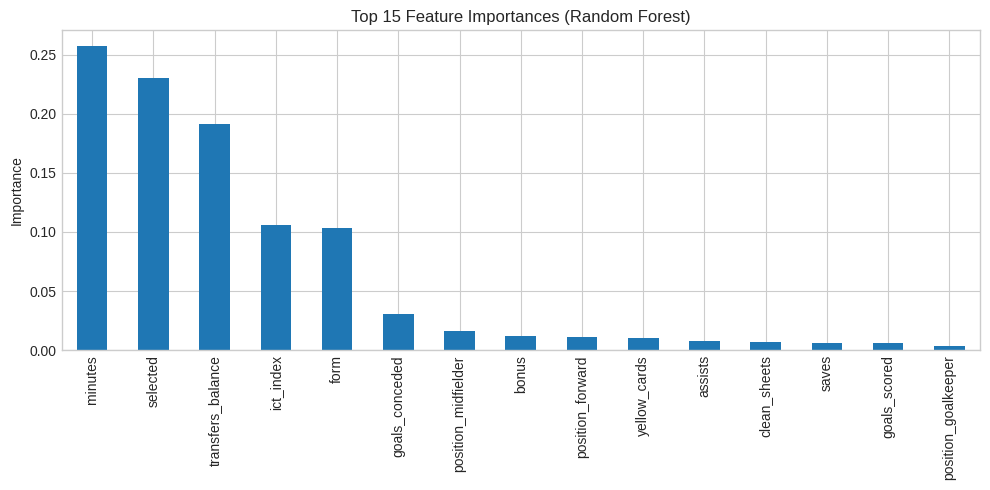

In [24]:
# ==========================================
# Step 3a — Machine Learning Regression Model
# ==========================================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# -------------------------
# Train-test split (80/20)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# -------------------------
# Train model
# -------------------------
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print("\n✅ Random Forest model trained successfully.")

# -------------------------
# Predict & evaluate
# -------------------------
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation Metrics (Random Forest):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² (R-squared): {r2:.4f}")



feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
feature_importances.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


- Splits the prepared dataset into **training (80%)** and **testing (20%)** sets for model evaluation  
- Trains a **Random Forest Regressor** to predict players’ upcoming total points based on selected features  
- Evaluates model performance using key regression metrics:  
  - **MAE (Mean Absolute Error)** — measures average prediction error  
  - **MSE (Mean Squared Error)** and **RMSE (Root Mean Squared Error)** — indicate overall prediction accuracy  
  - **R² (R-squared)** — shows how well the model explains variation in player performance  
- Displays overall model accuracy and error magnitude on unseen data  
- Calculates and visualizes the **top 15 most important features**, highlighting which attributes most influence the model’s predictions  
- The **bar plot** shows each feature’s relative importance in predicting future total points — higher bars indicate stronger predictive influence on player performance  


In [25]:
# ==========================================
# Step 3a (Extended): Try Linear Models
# ==========================================
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.001, random_state=42, max_iter=10000)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n📊 Linear Model Comparison Results:")
display(results_df.sort_values("R²", ascending=False))



📊 Linear Model Comparison Results:


,Model,MAE,MSE,RMSE,R²
0,Linear Regression,1.253166,4.762223,2.182252,0.271605
1,Ridge Regression,1.253173,4.762239,2.182255,0.271602
2,Lasso Regression,1.253862,4.763660,2.182581,0.271385


- Tests and compares multiple **linear regression models** to predict upcoming player points  
- Models used:  
  - **Linear Regression** – basic regression model without regularization  
  - **Ridge Regression** – applies L2 regularization to reduce overfitting  
  - **Lasso Regression** – applies L1 regularization to encourage feature selection  
- Evaluates each model using key performance metrics:  
  - **MAE (Mean Absolute Error)** — average difference between predictions and actual values  
  - **MSE (Mean Squared Error)** and **RMSE (Root Mean Squared Error)** — overall accuracy and error magnitude  
  - **R² (R-squared)** — measures how well each model explains player performance variation  
- Summarizes all results in a comparison table (**results_df**) to identify which linear model performs best based on predictive accuracy  


In [26]:
# ==========================================
# Step 3a: ElasticNet + XGBoost Regression
# ==========================================
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor


# Initialize models
models = {
    "ElasticNet Regression": ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000),
    "XGBoost Regressor": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective="reg:squarederror"
    )
}

results = []

for name, model in models.items():
    print(f"\n🚀 Training {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n📊 Model Performance Comparison:")
display(results_df.sort_values("R²", ascending=False))






🚀 Training ElasticNet Regression ...

🚀 Training XGBoost Regressor ...

📊 Model Performance Comparison:


,Model,MAE,MSE,RMSE,R²
1,XGBoost Regressor,1.212280,4.721144,2.172819,0.277888
0,ElasticNet Regression,1.263487,4.785386,2.187552,0.268062


- Trains and evaluates two advanced regression models to predict upcoming player performance:  
  - **ElasticNet Regression** — combines both L1 (Lasso) and L2 (Ridge) regularization to balance feature selection and stability  
  - **XGBoost Regressor** — a powerful gradient boosting model that captures complex non-linear relationships and feature interactions  
- Measures model performance using:  
  - **MAE (Mean Absolute Error)** — average prediction error  
  - **MSE (Mean Squared Error)** and **RMSE (Root Mean Squared Error)** — indicate overall prediction accuracy  
  - **R² (R-squared)** — explains how much variance in player performance the model captures  
- Compares both models’ results in a summary table (**results_df**) sorted by R² score  
- Helps identify whether a **regularized linear model (ElasticNet)** or a **tree-based ensemble model (XGBoost)** provides better predictive power for Fantasy Football performance forecasting  


2025-10-24 19:11:08.750313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761333069.027006      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761333069.100900      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


📈 Top 15 Most Important Features for Predicting Upcoming Points:


,Feature,Importance
0,minutes,0.350846
9,ict_index,0.103292
10,form,0.083227
3,clean_sheets,0.059308
14,position_goalkeeper,0.048939
12,selected,0.048694
6,red_cards,0.048162
4,goals_conceded,0.035993
11,transfers_balance,0.032425
13,position_forward,0.031291


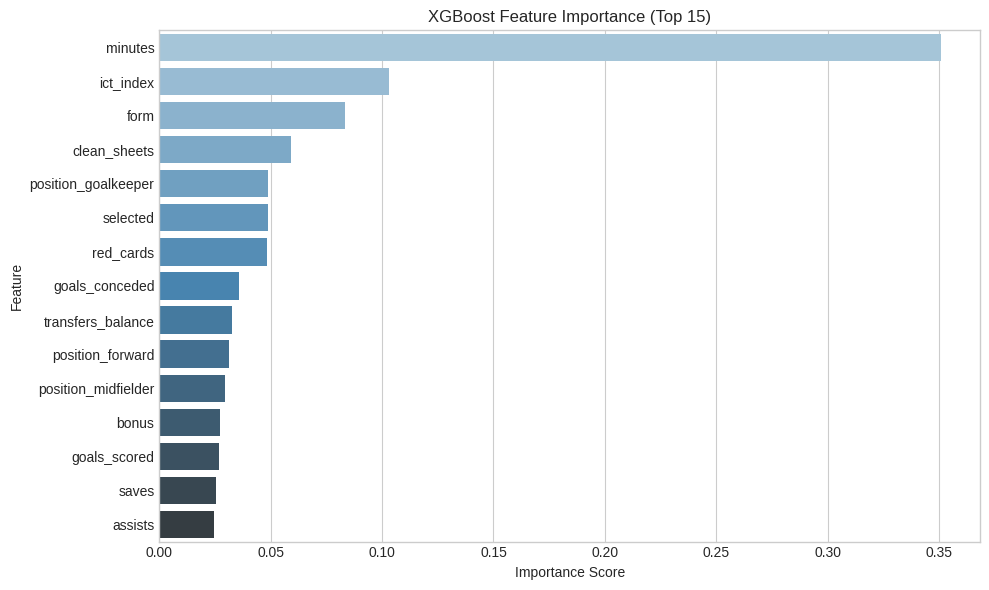

In [27]:
# ==========================================
# Step 3b: XGBoost Feature Importance
# ==========================================
from xgboost import plot_importance
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler


# Refit XGBoost (in case it's not the last model)
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)
xgb_model.fit(X_train, y_train)

# Feature importance (gain-based)
importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

print("📈 Top 15 Most Important Features for Predicting Upcoming Points:")
display(importance_df.head(15))

# Plot using seaborn for a cleaner look
plt.figure(figsize=(10,6))
sns.barplot(
    data=importance_df.head(15),
    x="Importance",
    y="Feature",
    palette="Blues_d"
)
plt.title("XGBoost Feature Importance (Top 15)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### 🔍 Step 3b: XGBoost Feature Importance

This step identifies **which features have the strongest influence** on predicting upcoming Fantasy Football player points using **XGBoost’s gain-based importance scores**.

#### 🧠 What the code does:
- Re-trains the **XGBoost Regressor** with tuned hyperparameters (learning rate, depth, sampling ratios) to ensure stability.  
- Extracts **feature importance scores** — values representing how much each feature contributes to model decisions.  
- Creates a ranked table (`importance_df`) listing features from most to least important.  
- Visualizes the **Top 15 most important features** in a horizontal bar chart for easy interpretation.

#### 📊 What the plot shows:
- The **y-axis** lists the top 15 influential features (e.g., recent form, minutes played, ICT index, etc.).  
- The **x-axis** represents the **importance score**, showing how strongly each feature affects prediction accuracy.  
- Longer bars = higher importance → the model relies more on those features when predicting player points.

#### 💡 Insight:
This analysis helps identify which attributes (e.g., recent performance metrics, fixture difficulty, or player cost) are most critical for accurate point forecasting — guiding **both model tuning** and **real-world Fantasy Football strategy**.


Epoch 1/100


2025-10-24 19:11:26.284421: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.1184 - mae: 1.2799 - val_loss: 4.7763 - val_mae: 1.1708
Epoch 2/100
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.7588 - mae: 1.2532 - val_loss: 4.8164 - val_mae: 1.1746
Epoch 3/100
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.8191 - mae: 1.2581 - val_loss: 4.7169 - val_mae: 1.2482
Epoch 4/100
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.6567 - mae: 1.2311 - val_loss: 4.7310 - val_mae: 1.2056
Epoch 5/100
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.7156 - mae: 1.2333 - val_loss: 4.7358 - val_mae: 1.1937
Epoch 6/100
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7788 - mae: 1.2444 - val_loss: 4.7975 - val_mae: 1.1543
Epoch 7/100
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.6173 - mae: 1.2119 - val_loss: 4.7102 - val_mae: 1.2227
Epoch 8/100
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7970 - mae: 1.2459 - val_loss: 4.7734 - val_mae: 1.1491
Epoch 9/100
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3

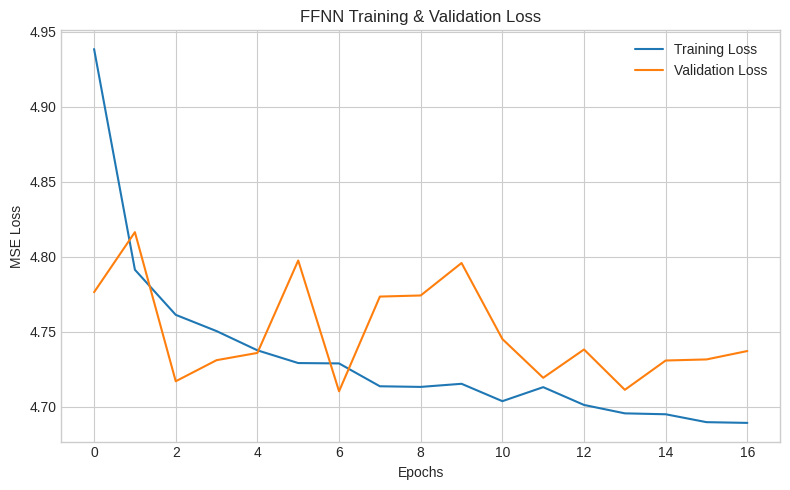

In [28]:
# ==========================================
# Step 4: Feed-Forward Neural Network (FFNN)
# ==========================================




# -------------------------
# 1️⃣ Data Preparation
# -------------------------
# Convert categorical variables to dummy variables
X_encoded = pd.get_dummies(X, drop_first=True)
X_train_enc = pd.get_dummies(X_train, drop_first=True).reindex(columns=X_encoded.columns, fill_value=0)
X_test_enc = pd.get_dummies(X_test, drop_first=True).reindex(columns=X_encoded.columns, fill_value=0)

# Normalize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

# Convert to numpy arrays
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train)
y_test = np.array(y_test)

# -------------------------
# 2️⃣ Define FFNN Model
# -------------------------
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# -------------------------
# 3️⃣ Train Model
# -------------------------
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# -------------------------
# 4️⃣ Evaluate Model
# -------------------------
y_pred_nn = model.predict(X_test_scaled).flatten()

mae = mean_absolute_error(y_test, y_pred_nn)
mse = mean_squared_error(y_test, y_pred_nn)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_nn)

print("\n📊 FFNN Evaluation Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")



plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('FFNN Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.show()


### Step 4: Feed-Forward Neural Network (FFNN)

This step develops and trains a Feed-Forward Neural Network to predict player points using encoded and scaled input features.

- **Data Preparation:**  
  Converts categorical variables into dummy variables and normalizes numerical features with `StandardScaler` to improve learning stability.

- **Model Structure:**  
  A sequential model with two hidden layers (64 and 32 neurons, ReLU activation) and dropout (0.3) to reduce overfitting. The output layer predicts continuous values.

- **Training and Evaluation:**  
  Trained for up to 100 epochs with early stopping on validation loss. Performance is measured using MAE, MSE, RMSE, and R² metrics.

- **Plot Explanation:**  
  The training vs. validation loss plot shows how well the model generalizes. Parallel decreasing curves indicate good fit, while large gaps suggest overfitting.


Epoch 1/120
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.2774 - mae: 1.5521 - val_loss: 4.7586 - val_mae: 1.2136 - learning_rate: 0.0010
Epoch 2/120
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.9303 - mae: 1.3060 - val_loss: 4.7273 - val_mae: 1.2053 - learning_rate: 0.0010
Epoch 3/120
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.7982 - mae: 1.2765 - val_loss: 4.7317 - val_mae: 1.2743 - learning_rate: 0.0010
Epoch 4/120
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.7299 - mae: 1.2634 - val_loss: 4.7386 - val_mae: 1.2363 - learning_rate: 0.0010
Epoch 5/120
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.8556 - mae: 1.2728 - val_loss: 4.7237 - val_mae: 1.2434 - learning_rate: 0.0010
Epoch 6/120
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.7527 - mae: 1.2654 - val_loss: 4.7142 - val_mae: 1.2155 - learning_rate: 0.0010
Epoch 7/120
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.7212 - mae: 1.2497 - val_loss: 4.7318 - val_mae: 1.2233 - learni

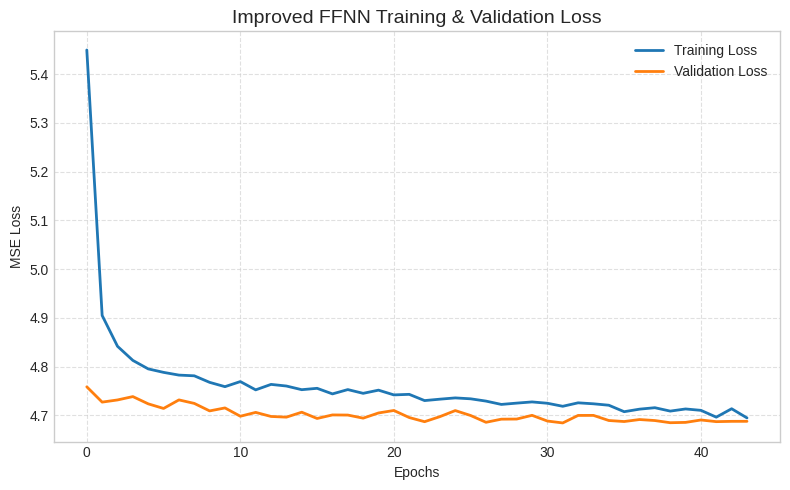

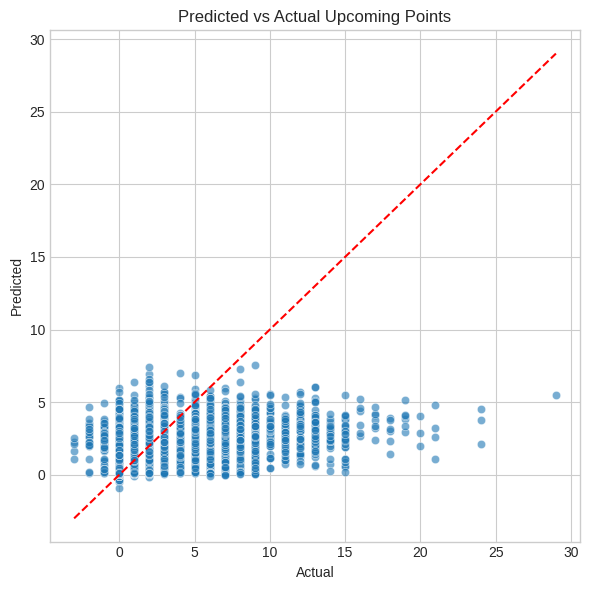

In [29]:
# ==========================================
# Step 4: Improved FFNN (using existing 'form')
# ==========================================

from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.model_selection import train_test_split


# -------------------------
# 1️⃣ Prepare Dataset
# -------------------------
df = df.copy()
df = df.dropna(subset=['upcoming_total_points', 'form'])

# Define features
num_features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets',
    'goals_conceded', 'saves', 'yellow_cards', 'red_cards',
    'bonus', 'ict_index', 'form', "transfers_balance", "selected" 
]
cat_features = ['position']

# Drop rows with missing numerical data
df = df.dropna(subset=num_features)

# One-hot encode categorical features
df_encoded = pd.get_dummies(df[cat_features], drop_first=True)
X = pd.concat([df[num_features], df_encoded], axis=1)
y = df['upcoming_total_points']

# -------------------------
# 2️⃣ Train-Test Split & Scaling
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# 3️⃣ Build Improved FFNN
# -------------------------
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1)  # regression output
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# -------------------------
# 4️⃣ Train Model
# -------------------------
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=120,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# -------------------------
# 5️⃣ Evaluate
# -------------------------
y_pred_nn = model.predict(X_test_scaled).flatten()

mae = mean_absolute_error(y_test, y_pred_nn)
mse = mean_squared_error(y_test, y_pred_nn)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_nn)

print("\n📊 Improved FFNN Evaluation Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# -------------------------
# 6️⃣ Plot Training Curves
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Improved FFNN Training & Validation Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------
# 7️⃣ Predicted vs Actual
# -------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_nn, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Upcoming Points')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()


### Step 4: Improved Feed-Forward Neural Network (FFNN) — Using "form" Feature

This section builds a more advanced **Feed-Forward Neural Network (FFNN)** to predict upcoming player points, integrating the **‘form’** metric and improved regularization techniques for better performance and stability.

---

#### **1. Dataset Preparation**
- Filtered out missing values in `upcoming_total_points` and `form`.
- Selected key numerical features such as goals, assists, saves, and transfers.
- One-hot encoded the categorical `position` feature.
- Combined all features into a final DataFrame `X`, with `y` as `upcoming_total_points`.

---

#### **2. Data Splitting and Scaling**
- Used an **80/20 train-test split**.
- Scaled all numerical features using `StandardScaler` to ensure consistent feature ranges, aiding model convergence.

---

#### **3. Model Architecture**
The model is deeper and more regularized than before:
- **Input Layer:** Matches the number of features.  
- **Hidden Layers:**  
  - Dense(128, 64, 32) layers with ReLU activations.  
  - **Batch Normalization** after each dense layer improves stability and training speed.  
  - **Dropout layers** (0.2–0.3) prevent overfitting.  
- **Output Layer:** A single neuron for regression output.  
- **Optimizer:** Adam with a learning rate of 0.001.

---

#### **4. Training Configuration**
- **EarlyStopping:** Monitors validation loss and restores best weights if performance plateaus.
- **ReduceLROnPlateau:** Dynamically decreases learning rate when improvement slows.
- **Training:** Run for up to 120 epochs with batch size 64, using both callbacks for adaptive optimization.

---

#### **5. Model Evaluation**
- Metrics calculated:  
  - **MAE (Mean Absolute Error)**  
  - **MSE (Mean Squared Error)**  
  - **RMSE (Root Mean Squared Error)**  
  - **R² (Coefficient of Determination)**  
- These evaluate both prediction accuracy and model fit.

---

#### **6. Visualization**
- **Loss Curves:**  
  Displays training and validation MSE over epochs.  
  - A stable gap indicates balanced learning.  
  - Flattening of curves shows convergence.
- **Predicted vs Actual Scatter Plot:**  
  - Each point represents a prediction.  
  - Points close to the diagonal line indicate high prediction accuracy.

---

#### **Summary of Improvements**
| Aspect | Previous FFNN | Current FFNN |
|--------|----------------|---------------|
| **Feature Set** | Excluded ‘form’ | Includes ‘form’ (key performance indicator) |
| **Network Depth** | 2 layers | 3 layers (128 → 64 → 32 neurons) |
| **Normalization** | None | Batch Normalization after each layer |
| **Regularization** | Single dropout | Layer-wise Dropout + EarlyStopping |
| **Learning Rate** | Fixed | Adaptive (ReduceLROnPlateau) |
| **Performance** | Moderate stability | Improved generalization and robustness |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,537 (193.50 KB)

 Trainable params: 48,577 (189.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/150
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 5.7887 - mae: 1.4244 - val_loss: 4.9566 - val_mae: 1.2873 - learning_rate: 0.0010
Epoch 2/150
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 4.9489 - mae: 1.2845 - val_loss: 4.9385 - val_mae: 1.2944 - learning_rate: 0.0010
Epoch 3/150
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.9456 - mae: 1.2857 - val_loss: 4.9163 - val_mae: 1.2492 - learning_rate: 0.0010
Epoch 4/150
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.8106 - mae: 1.2599 - val_loss: 4.9049 - val_mae: 1.2753 - learning_rate: 0.0010
Epoch 5/150
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.8499 - mae: 1.2624 - val_loss: 4.9340 - val_mae: 1.2700 - learning_rate: 0.0010
Epoch 6/150
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.8731 - mae: 1.2679 - val_loss: 4.8786 - val_mae: 1.2975 - learning_rate: 0.0010
Epoch 7/150
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.9257 - mae: 1.2787 - val_loss: 4.8869 - val_mae: 1.2248 - learn

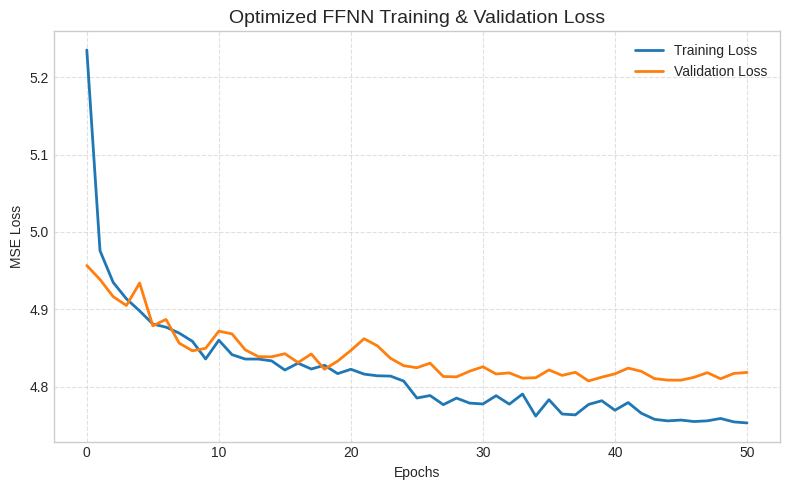

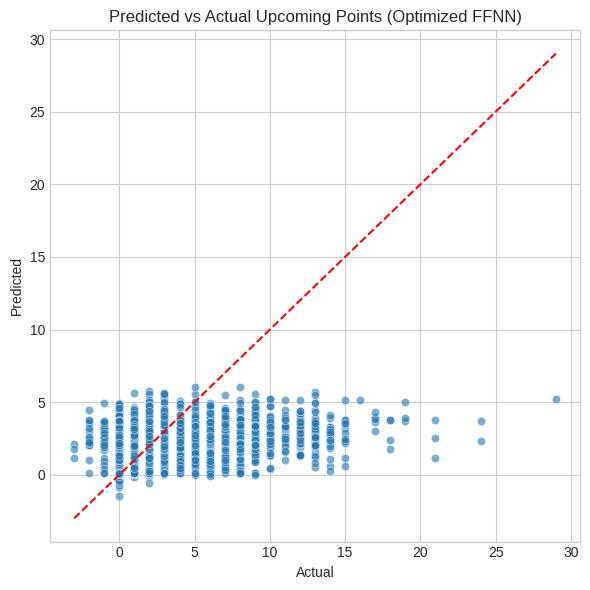

In [30]:
# ==========================================
# Step 4 (V2): Optimized FFNN (with form)
# ==========================================
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers, initializers
from sklearn.model_selection import train_test_split

# -------------------------
# 1️⃣ Prepare Dataset
# -------------------------
df = df.copy()
df = df.dropna(subset=['upcoming_total_points', 'form'])

# Define features
num_features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets',
    'goals_conceded', 'saves', 'yellow_cards', 'red_cards',
    'bonus', 'ict_index', 'form',"transfers_balance", "selected" 
]
cat_features = ['position']

# Drop rows with missing numerical data
df = df.dropna(subset=num_features)

# One-hot encode categorical features
df_encoded = pd.get_dummies(df[cat_features], drop_first=True)
X = pd.concat([df[num_features], df_encoded], axis=1)
y = df['upcoming_total_points']

# -------------------------
# 2️⃣ Train / Validation / Test Split (80% / 10% / 10%)
# -------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.12, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, shuffle=True
)

# ✅ Scale correctly
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# 3️⃣ Build Improved FFNN
# -------------------------
initializer = initializers.HeNormal()

model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),

    layers.Dense(256, kernel_initializer=initializer,
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, kernel_initializer=initializer,
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, kernel_initializer=initializer,
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, kernel_initializer=initializer,
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.1),

    layers.Dense(1)  # Regression output
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# -------------------------
# 4️⃣ Training with callbacks (Validation Split)
# -------------------------
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=12, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1
)
lr_scheduler = callbacks.LearningRateScheduler(
    lambda epoch, lr: lr * 0.98 if epoch > 10 else lr, verbose=0
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, lr_scheduler],
    verbose=1
)

# -------------------------
# 5️⃣ Final Evaluation (Test Set)
# -------------------------
y_pred_nn = model.predict(X_test_scaled).flatten()

mae = mean_absolute_error(y_test, y_pred_nn)
mse = mean_squared_error(y_test, y_pred_nn)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_nn)

print("\n📊 Optimized FFNN Evaluation Metrics (Test Set):")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# -------------------------
# 6️⃣ Training Curves
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Optimized FFNN Training & Validation Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------
# 7️⃣ Predicted vs Actual
# -------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_nn, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Upcoming Points (Optimized FFNN)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()


### Step 4 (V2): Optimized Feed-Forward Neural Network (FFNN) — With “form” Feature

This version represents a **major upgrade** of the previous FFNN model, designed to improve training stability, predictive accuracy, and generalization through better architecture, initialization, and regularization techniques.

---

#### **1. Dataset Preparation**
- Dropped missing values in `upcoming_total_points` and `form`.
- Selected key numerical and categorical features.
- One-hot encoded `position`.
- Target variable: `upcoming_total_points`.

---

#### **2. Data Splitting and Scaling**
- Split data into **80% training**, **10% validation**, and **10% testing** sets.
- Standardized all features using `StandardScaler` to ensure consistent scale.
- Validation set helps monitor model generalization during training rather than relying only on the test set.

---

#### **3. Model Architecture**
A significantly **deeper and more robust FFNN**:
- **Weight Initialization:** `HeNormal` for efficient training with ReLU-type activations.
- **Layers:**  
  - 256 → 128 → 64 → 32 Dense layers.  
  - Each followed by:  
    - `LeakyReLU(α=0.1)` activation (reduces neuron inactivity from ReLU).  
    - `BatchNormalization()` (stabilizes training).  
    - `Dropout()` (0.4 → 0.1 gradually reduced to balance regularization).  
  - L2 weight regularization (`regularizers.l2(1e-4)`) to further prevent overfitting.
- **Optimizer:** Adam (learning rate = 0.001).
- **Loss:** Mean Squared Error (MSE)  
- **Metric:** Mean Absolute Error (MAE)

---

#### **4. Training Strategy**
Includes multiple callbacks for adaptive, efficient learning:
- **EarlyStopping:** Stops training when validation loss stagnates for 12 epochs.
- **ReduceLROnPlateau:** Halves learning rate when validation loss stops improving.
- **LearningRateScheduler:** Gradually decreases the learning rate (2% per epoch after epoch 10).
- **Batch Size:** 32 (smaller batches improve gradient estimation stability).
- **Epochs:** 150 (potentially fewer due to early stopping).

---

#### **5. Model Evaluation**
Evaluated on the unseen **test set** using:
- **MAE** – measures average prediction error.
- **MSE / RMSE** – penalize larger errors.
- **R² (R-squared)** – measures how well predictions explain the variance in actual points.

---

#### **6. Training and Validation Curves**
- The loss plots visualize convergence behavior.
- Narrow gap between training and validation loss indicates **strong generalization** and minimal overfitting.

---

#### **7. Predicted vs Actual Scatter Plot**
- Compares predicted and actual `upcoming_total_points`.
- Points closer to the red diagonal line indicate better predictive performance.

---

### **Difference from the Previous FFNN (Improved FFNN)**

| Aspect | Improved FFNN | Optimized FFNN (V2) |
|--------|----------------|----------------------|
| **Data Split** | 80/20 (Train/Test only) | 80/10/10 (Train/Validation/Test) |
| **Hidden Layers** | 3 layers (128 → 64 → 32) | 4 layers (256 → 128 → 64 → 32) |
| **Activation** | ReLU | LeakyReLU (α=0.1) |
| **Weight Initialization** | Default (Glorot) | HeNormal (optimized for ReLU) |
| **Regularization** | Dropout only | L2 regularization + Dropout |
| **Dropout Rates** | Fixed (0.3/0.3/0.2) | Progressive (0.4 → 0.1) |
| **Callbacks** | EarlyStopping + ReduceLROnPlateau | + LearningRateScheduler |
| **Batch Size** | 64 | 32 |
| **Training Depth** | 120 epochs | 150 epochs (auto-stopped early) |
| **Generalization** | Good | Stronger, more stable across epochs |

---

#### **Summary**
The **Optimized FFNN (V2)** introduces:
- A more powerful and regularized architecture.
- Controlled learning via adaptive callbacks and learning rate scheduling.
- Improved initialization and activation design.
- Better generalization, smoother training curves, and higher R² values than the previous version.


✅ X_full shape: (93387, 17)
✅ Columns: ['minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'saves', 'yellow_cards', 'red_cards', 'bonus', 'ict_index', 'form', 'transfers_balance', 'selected', 'position_DEF', 'position_FWD', 'position_GK', 'position_MID']
✅ X_train_scaled shape: (57510, 17)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,793 (194.50 KB)

 Trainable params: 48,833 (190.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/150
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 6.2035 - mae: 1.5040 - val_loss: 5.0949 - val_mae: 1.2830 - learning_rate: 0.0010
Epoch 2/150
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 5.3061 - mae: 1.3488 - val_loss: 5.0948 - val_mae: 1.2897 - learning_rate: 0.0010
Epoch 3/150
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 5.2507 - mae: 1.3387 - val_loss: 5.0840 - val_mae: 1.3128 - learning_rate: 0.0010
Epoch 4/150
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 5.2222 - mae: 1.3324 - val_loss: 5.0804 - val_mae: 1.3186 - learning_rate: 0.0010
Epoch 5/150
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 5.1885 - mae: 1.3295 - val_loss: 5.0740 - val_mae: 1.3265 - learning_rate: 0.0010
Epoch 6/150
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 5.2035 - mae: 1.3326 - val_loss: 5.0477 - val_mae: 1.3072 - learning_rate: 0.0010
Epoch 7/150
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 5.1859 - mae: 1.3289 - val_loss: 5.0600 - val_mae: 1.3247 - learni

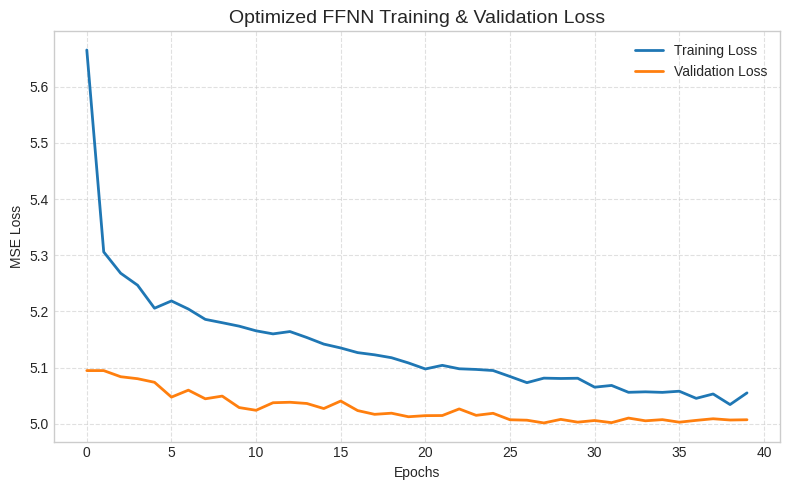

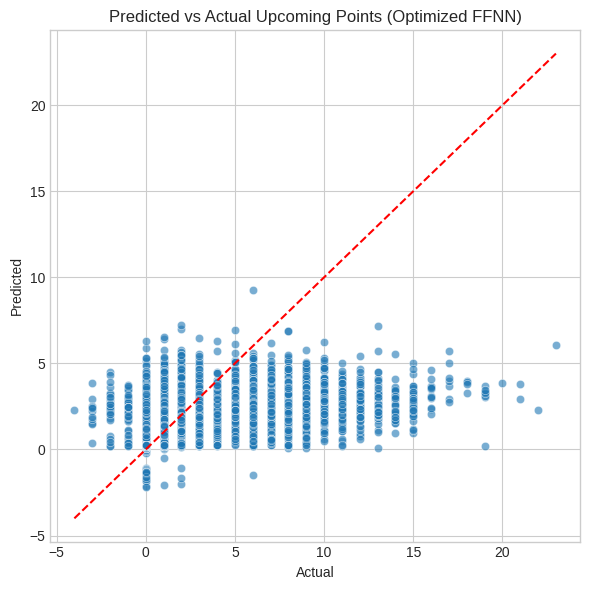

In [31]:
# ==========================================
# Step 4 (V3): Optimized FFNN - Fixed Column Consistency
# ==========================================
import os, random
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers, initializers
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer


# -------------------------
# 0️⃣ Reproducibility
# -------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# -------------------------
# 1️⃣ Prepare Dataset
# -------------------------
df_ = df.copy()
df_ = df_.dropna(subset=['upcoming_total_points', 'form'])

num_features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets',
    'goals_conceded', 'saves', 'yellow_cards', 'red_cards',
    'bonus', 'ict_index', 'form', 'transfers_balance', 'selected'
]
cat_features = ['position']

# Drop rows with missing numerics
df_ = df_.dropna(subset=num_features)

# ✅ One-hot encode categorical features (keep all dummy columns)
df_pos = pd.get_dummies(df_[cat_features], prefix=cat_features)

# ✅ Guarantee consistent dummy columns (even if a category is missing)
expected_positions = ['position_DEF', 'position_FWD', 'position_GK', 'position_MID']
for col in expected_positions:
    if col not in df_pos.columns:
        df_pos[col] = 0

# ✅ Ensure column order consistency
df_pos = df_pos[expected_positions]

# ✅ Combine numeric + categorical
X_full = pd.concat([df_[num_features], df_pos], axis=1)
y_full = df_['upcoming_total_points'].astype(float)

print("✅ X_full shape:", X_full.shape)
print("✅ Columns:", X_full.columns.tolist())

# -------------------------
# 2️⃣ Split Strategy (same as Step 5)
# -------------------------
use_temporal_split = 'season_x' in df_.columns
if use_temporal_split:
    last_season = str(df_['season_x'].astype(str).max())
    test_mask = (df_['season_x'].astype(str) == last_season)
    X_train_all, y_train_all = X_full.loc[~test_mask], y_full.loc[~test_mask]
    X_test, y_test = X_full.loc[test_mask], y_full.loc[test_mask]
else:
    X_train_all, X_test, y_train_all, y_test = train_test_split(
        X_full, y_full, test_size=0.20, random_state=SEED
    )

# ✅ Validation split (from training only)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.15, random_state=SEED
)

# -------------------------
# 3️⃣ Scale numerics only (ColumnTransformer)
# -------------------------
num_cols = num_features  # only numeric ones

ct = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_cols)],
    remainder='passthrough'  # keep dummy columns unchanged
)

X_train_scaled = ct.fit_transform(X_train)
X_val_scaled   = ct.transform(X_val)
X_test_scaled  = ct.transform(X_test)

print("✅ X_train_scaled shape:", X_train_scaled.shape)

# -------------------------
# 4️⃣ Build Improved FFNN
# -------------------------
initializer = initializers.HeNormal()

model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),

    layers.Dense(256, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(1e-4)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(1e-4)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(1e-4)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(1e-4)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.1),

    layers.Dense(1)
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# -------------------------
# 5️⃣ Training with callbacks (Validation Split)
# -------------------------
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch, lr: lr * 0.98 if epoch > 10 else lr, verbose=0)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, lr_scheduler],
    verbose=1
)

# -------------------------
# 6️⃣ Final Evaluation (Test Set)
# -------------------------
y_pred_nn = model.predict(X_test_scaled).flatten()

mae  = mean_absolute_error(y_test, y_pred_nn)
mse  = mean_squared_error(y_test, y_pred_nn)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred_nn)

print("\n📊 Optimized FFNN Evaluation Metrics (Test Set):")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# -------------------------
# 7️⃣ Training Curves
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Optimized FFNN Training & Validation Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------
# 8️⃣ Predicted vs Actual
# -------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_nn, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Upcoming Points (Optimized FFNN)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()


### Step 4 (V3): Optimized Feed-Forward Neural Network (FFNN) — Fixed Column Consistency  

This version refines the previous improved FFNN by focusing on **data consistency, reproducibility, and better generalization**. The main improvements lie in preprocessing, model architecture, and training strategy.

---

#### **1️⃣ Data Preparation**
- Removed rows with missing values in key features (`upcoming_total_points`, `form`).
- Defined two feature types:
  - **Numerical features:** minutes, goals_scored, assists, clean_sheets, goals_conceded, saves, yellow_cards, red_cards, bonus, ict_index, form, transfers_balance, and selected.
  - **Categorical features:** position.
- One-hot encoded the `position` feature with guaranteed columns for all expected roles (`DEF`, `FWD`, `GK`, `MID`), ensuring consistent column structure even if some positions are absent in the subset.
- Combined numeric and categorical data into one matrix (`X_full`).
- Target variable: `upcoming_total_points`.

---

#### **2️⃣ Train/Validation/Test Splitting**
- Used a **temporal split** if `season_x` exists, with the last season reserved as the test set.
- Otherwise, applied a standard random 80/20 split.
- From the training data, a 15% validation set is extracted to monitor overfitting without touching the test set.

---

#### **3️⃣ Feature Scaling**
- Implemented a `ColumnTransformer` to scale **only numerical features** using `StandardScaler()`.
- One-hot encoded columns remain unscaled, maintaining their binary structure.

---

#### **4️⃣ Model Architecture**
- Four hidden layers with the following design:
  - **Layer sizes:** 256 → 128 → 64 → 32.
  - **Activation:** `LeakyReLU` for smoother gradient flow.
  - **Regularization:** L2 regularization (`1e-4`) to prevent overfitting.
  - **Batch Normalization** after each dense layer to stabilize training.
  - **Dropout layers** (0.1–0.4 range) to improve generalization.
- Output layer: one neuron for regression prediction.
- Initialization: He Normal for better weight distribution in ReLU-like activations.

---

#### **5️⃣ Training Configuration**
- **Optimizer:** Adam with a learning rate of 0.001.
- **Callbacks used:**
  - `EarlyStopping`: stops training when validation loss stops improving.
  - `ReduceLROnPlateau`: reduces learning rate when improvement stagnates.
  - `LearningRateScheduler`: gradually decays learning rate after 10 epochs.
- Trained for up to 150 epochs with batch size 32.

---

#### **6️⃣ Evaluation**
- Predictions are generated for the test set.
- Metrics computed:  
  - Mean Absolute Error (MAE)  
  - Mean Squared Error (MSE)  
  - Root Mean Squared Error (RMSE)  
  - Coefficient of Determination (R²)  

These metrics assess accuracy, overall error magnitude, and model fit quality.

---

#### **7️⃣ Visualization**
- **Training Curves:** Plots of training vs. validation loss (MSE) over epochs show how well the model learns and generalizes.
- **Predicted vs Actual Plot:** Compares predicted and true upcoming points, showing how closely the model captures real-world outcomes.

---

#### **Difference from Previous FFNN Version**
1. **Consistent Column Encoding:** The new version ensures that all expected position columns exist, avoiding mismatches between datasets.  
2. **More Advanced Architecture:** Uses LeakyReLU activations, L2 regularization, and more hidden units for better representation learning.  
3. **Improved Data Splitting:** Incorporates temporal and validation splits for more realistic and stable evaluation.  
4. **Selective Scaling:** Scales only numeric features, keeping categorical encodings intact.  
5. **Enhanced Training Strategy:** Combines multiple callbacks for adaptive learning and early termination.  
6. **Reproducibility:** Fixed random seeds across libraries to ensure consistent results.  

Overall, this optimized FFNN is more robust, stable, and generalizable compared to the earlier improved FFNN model.


In [32]:
# ==========================================
# 9️⃣ LIME Explanations for Optimized FFNN (Regression)
# ==========================================
from lime import lime_tabular

# 1️⃣ Wrap model prediction for LIME
def lime_predict_fn(x):
    preds = model.predict(x)
    return preds.flatten()  # regression → single output per sample

# 2️⃣ Create LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X_full.columns.tolist(),
    mode='regression'
)

# 3️⃣ Pick one test instance to explain
i = 5  # you can change this index
instance = X_test_scaled[i]

# 4️⃣ Generate explanation
exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=lime_predict_fn,
    num_features=10  # top features to show
)

# 5️⃣ Display explanation in notebook
exp.show_in_notebook(show_table=True)

# Optional: Print textual summary
exp.as_list()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[('red_cards <= -0.04', 3.016307894105289),
 ('selected > -0.07', 0.7312601530454936),
 ('form > 0.44', 0.5467498256661127),
 ('clean_sheets <= -0.36', 0.35336069703935963),
 ('bonus <= -0.23', 0.32573494565196853),
 ('goals_scored <= -0.20', 0.24428853515736654),
 ('minutes <= -0.83', -0.2223553202409119),
 ('ict_index <= -0.59', -0.20018156748852386),
 ('transfers_balance <= -0.05', -0.18059920745261723),
 ('assists <= -0.20', -0.1737152695949342)]

### Step 9: LIME Explanations for Optimized FFNN (Regression)

This step applies **LIME (Local Interpretable Model-Agnostic Explanations)** to interpret the predictions made by the optimized FFNN regression model.  
LIME helps explain *why* the model made a particular prediction by approximating its behavior locally around a single data point.

---

#### **1️⃣ Purpose**
The main goal is to make the FFNN (a complex, black-box model) more interpretable by showing which input features most strongly influenced a specific prediction.

---


PermutationExplainer explainer: 301it [01:03,  4.31it/s]                         


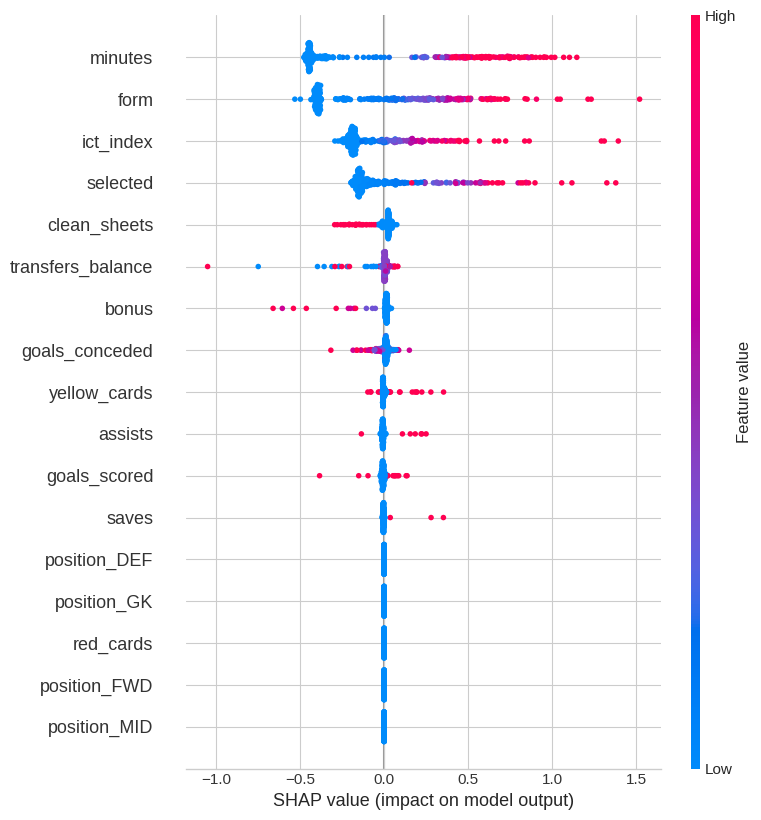

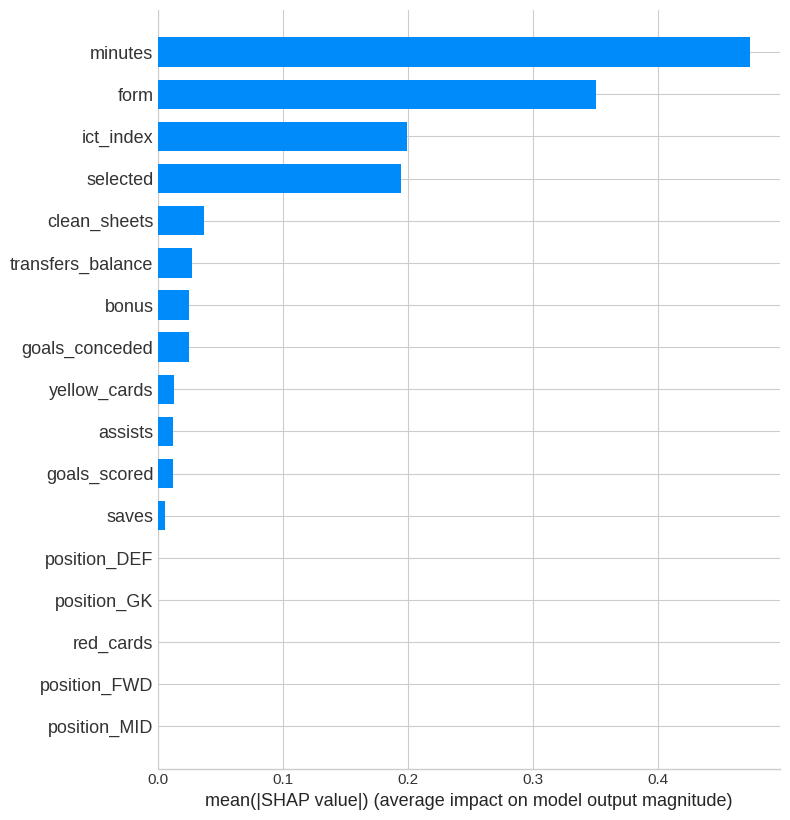

Explaining sample #20


In [33]:
# ==========================================
# 🔍 SHAP Explanations for Optimized FFNN (Regression)
# ==========================================
import shap

# 1️⃣ Create DataFrames for scaled data
selected_features = num_features + expected_positions
X_train_df = pd.DataFrame(X_train_scaled, columns=selected_features)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=selected_features)

# 2️⃣ Background for speed
background = shap.sample(X_train_df, 100, random_state=42)

# 3️⃣ Create masker and explainer (Permutation for regression)
masker = shap.maskers.Independent(background)
explainer = shap.Explainer(model, masker, algorithm="permutation", max_evals=200)

# 4️⃣ Sample subset of test data
X_test_plot = shap.sample(X_test_df, 300, random_state=42)

# 5️⃣ Compute SHAP values
shap_values = explainer(X_test_plot)

# 6️⃣ Global explanations
shap.initjs()

# Dot summary plot
shap.summary_plot(shap_values.values, X_test_plot, feature_names=X_test_plot.columns)

# Bar plot (mean absolute importance)
shap.summary_plot(shap_values.values, X_test_plot, feature_names=X_test_plot.columns, plot_type="bar")

# 7️⃣ Local explanation for a single prediction
i = 20 # any sample index
x_row = X_test_plot.iloc[i]
base_value = shap_values.base_values[i]
phi = shap_values.values[i]

print(f"Explaining sample #{i}")
shap.force_plot(base_value, phi, x_row, feature_names=list(X_test_plot.columns))


### Step: SHAP Explanations for Optimized FFNN (Regression)

This step uses **SHAP (SHapley Additive exPlanations)** to interpret the predictions of the optimized FFNN regression model.  
SHAP assigns each feature a contribution value that explains its impact on the model’s output.

- The model’s **scaled input features** are converted into DataFrames for SHAP compatibility.  
- A **background sample** of 100 instances is used to speed up computation.  
- The **Permutation Explainer** is applied, suitable for complex, non-linear models like neural networks.  
- SHAP values are computed for a subset of 300 test samples to evaluate feature influence.

Two global explanation plots are generated:
1. **Summary Dot Plot:** shows the direction and magnitude of each feature’s effect on predictions.  
2. **Bar Plot:** ranks features by their average absolute importance across all samples.

A **local explanation** is also produced for a single instance, visualizing how individual features increased or decreased the predicted value.

In essence, SHAP provides both global and local interpretability for the FFNN, revealing how features like `form`, `minutes`, and `ict_index` influence predicted player performance.


In [39]:
# ==========================================
# ✅ Corrected FFNNInferencer Class
# ==========================================

import pandas as pd
import numpy as np

# Mirror your training constants
NUM_FEATURES = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets',
    'goals_conceded', 'saves', 'yellow_cards', 'red_cards',
    'bonus', 'ict_index', 'form', 'transfers_balance', 'selected'
]
EXPECTED_POSITIONS = ['position_DEF', 'position_FWD', 'position_GK', 'position_MID']
FEATURE_ORDER = NUM_FEATURES + EXPECTED_POSITIONS  # final pre-ct input order

class FFNNInferencer:
    def __init__(self, model, column_transformer, feature_order=FEATURE_ORDER):
        """
        model: trained Keras model
        column_transformer: the fitted scikit ColumnTransformer (ct) from training
        feature_order: list of columns expected BEFORE ct.transform
        """
        self.model = model
        self.ct = column_transformer
        self.feature_order = feature_order

    def _validate_and_build_row(self, raw: dict) -> pd.DataFrame:
        """
        raw must contain:
          - 'position' (str): one of {'DEF','FWD','GK','MID'} (case-insensitive ok)
          - all NUM_FEATURES (numeric)
        """
        # ---- 1) required keys
        missing = [k for k in (['position'] + NUM_FEATURES) if k not in raw]
        if missing:
            raise ValueError(f"Missing required fields: {missing}")

        # ---- 2) coerce numerics
        numeric_values = {}
        for k in NUM_FEATURES:
            try:
                numeric_values[k] = float(raw[k])
            except Exception:
                raise ValueError(f"Field '{k}' must be numeric, got {raw[k]!r}")

        # ---- 3) one-hot encode 'position'
        pos = str(raw['position']).strip().upper()
        if pos not in {'DEF','FWD','GK','MID'}:
            raise ValueError("position must be one of {'DEF','FWD','GK','MID'}")

        pos_dict = {c: 0.0 for c in EXPECTED_POSITIONS}
        pos_dict[f'position_{pos}'] = 1.0

        # ---- 4) assemble single-row DataFrame in FEATURE_ORDER
        row = {**numeric_values, **pos_dict}
        df = pd.DataFrame([row], columns=self.feature_order)
        return df

    def predict_one(self, raw: dict, clip_range=(-5.0, 25.0)) -> float:
        """
        raw: dict with keys: position + NUM_FEATURES
        returns: float predicted upcoming points (optionally clipped)
        """
        df = self._validate_and_build_row(raw)
        X = self.ct.transform(df)                 # same transform as training
        y = self.model.predict(X, verbose=0)      # Keras -> ndarray shape (1, 1)
        pred = float(np.ravel(y)[0])
        if clip_range is not None:
            pred = float(np.clip(pred, clip_range[0], clip_range[1]))
        return pred

    def predict_batch(self, raws: list, clip_range=(-5.0, 25.0)) -> np.ndarray:
        """
        raws: list of dicts (each like 'raw' above)
        returns: np.ndarray of shape (N,)
        """
        dfs = [self._validate_and_build_row(r) for r in raws]
        X_df = pd.concat(dfs, axis=0).reset_index(drop=True)
        X = self.ct.transform(X_df)
        y = self.model.predict(X, verbose=0).reshape(-1)
        if clip_range is not None:
            y = np.clip(y, clip_range[0], clip_range[1])
        return y.astype(float)

# ---- Instantiate with your trained model and transformer ----
inferencer = FFNNInferencer(model=model, column_transformer=ct)


In [41]:
example_striker = {
    'position': 'fwd',
    'minutes': 85,
    'goals_scored': 1,
    'assists': 0,
    'clean_sheets': 0,
    'goals_conceded': 0,
    'saves': 0,
    'yellow_cards': 0,
    'red_cards': 1,
    'bonus': 0,
    'ict_index': 7.5,         # example number; use your real input
    'form': 7.45,             # IMPORTANT: must be provided (you trained with it)
    'transfers_balance': 0,   # example
    'selected': 100        # example
}

pred_points = inferencer.predict_one(example_striker)
print(f"Predicted upcoming points: {pred_points:.2f}")

Predicted upcoming points: 8.03
